In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

Using TensorFlow backend.
/home/eduardo/DL_Environment/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eduardo/DL_Environment/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eduardo/DL_Environment/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eduardo/DL_Environment/lib/pytho

In [2]:
train_clean = pd.read_csv('data/train_clean.csv')
test_clean = pd.read_csv('data/test_clean.csv')
test = pd.read_csv('data/test.csv')
train_clean.shape, test_clean.shape

((1458, 87), (1459, 85))

In [3]:
y_train = train_clean['SalePrice']
y_train_normalized = train_clean['Target_Normalized']

**MODELOS LINEALES**

In [4]:
data_clean = pd.concat((train_clean.drop(['SalePrice', 'Target_Normalized'], axis=1), test_clean)).reset_index(drop=True)
data_clean.shape

(2917, 85)

In [5]:
variables_numericas = data_clean.dtypes[data_clean.dtypes != "object"].index
for col in variables_numericas:
    data_clean[col] = RobustScaler().fit_transform(data_clean[col].values.reshape(-1,1))

En los modelos lineales hay que codificar las variables categóricas usando el one-hot encoding:

In [6]:
data_clean_dummies = pd.get_dummies(data_clean).reset_index(drop=True)
data_clean_dummies.shape

(2917, 225)

Una vez aplicado el one-hot, se eliminan las variables binarias con varianza casi nula:

In [7]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [8]:
numeric_feats = data_clean_dummies.dtypes[data_clean_dummies.dtypes != "object"].index

vars_with_good_variance = variance_threshold_selector(data_clean_dummies[numeric_feats], 0.001).columns.tolist()
candidate_vars = list(set(numeric_feats) - set(vars_with_good_variance) - {'Yr_sold_age'})
candidate_vars

['Exterior1st_ImStucc',
 'Is_remodeled',
 'Is_garage_remodel',
 'Functional_Sev',
 'Exterior2nd_Other',
 'Exterior1st_Stone',
 'Exterior1st_AsphShn',
 'MSSubClass_1-1/2 STORY PUD - ALL AGES',
 'Electrical_Mix',
 'Exterior1st_CBlock']

In [9]:
for col in candidate_vars:
    print(data_clean_dummies[col].value_counts())

0    2916
1       1
Name: Exterior1st_ImStucc, dtype: int64
0.0    2917
Name: Is_remodeled, dtype: int64
0.0    2917
Name: Is_garage_remodel, dtype: int64
0    2915
1       2
Name: Functional_Sev, dtype: int64
0    2916
1       1
Name: Exterior2nd_Other, dtype: int64
0    2915
1       2
Name: Exterior1st_Stone, dtype: int64
0    2915
1       2
Name: Exterior1st_AsphShn, dtype: int64
0    2916
1       1
Name: MSSubClass_1-1/2 STORY PUD - ALL AGES, dtype: int64
0    2916
1       1
Name: Electrical_Mix, dtype: int64
0    2915
1       2
Name: Exterior1st_CBlock, dtype: int64


In [10]:
data_clean_dummies.drop(candidate_vars,axis=1,inplace=True)

In [11]:
train_clean_dummies = data_clean_dummies[:train_clean.shape[0]]
test_clean_dummies = data_clean_dummies[train_clean.shape[0]:]

In [12]:
train_clean_dummies.isna().sum().sum(), y_train_normalized.isna().sum()

(0, 0)

In [13]:
def rmsle(y_true, y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true=y_true, y_pred=y_pred))

In [14]:
def rmsle_bayesian(y_true, y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true=np.expm1(y_true), y_pred=np.expm1(y_pred)))

In [15]:
bayes_cv_tuner = BayesSearchCV(
    estimator = Lasso(random_state=1),
    search_spaces = {
        'alpha': (0.0000001, 1.0, 'uniform'),
        'max_iter': (1000, 10000)
    },    
    scoring = make_scorer(rmsle_bayesian, greater_is_better=False),
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 5,
    n_iter = 40,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest RMSLE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    all_models.to_csv("lassos_cv_results.csv")

In [16]:
#result = bayes_cv_tuner.fit(train_clean_dummies.values, y_train_normalized.values, callback=status_print)

In [17]:
model = Lasso(alpha = 0.00041876997499490907, max_iter=1059, random_state=1)

In [18]:
def KFoldEnsemble(train, test, y_train, model, k=5):
    kf = KFold(n_splits = k, random_state = 0, shuffle = True)
    rmsle_list = []
    
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(train)):
        trn_x, val_x = train.loc[trn_idx], train.loc[val_idx]
        trn_y, val_y = y_train[trn_idx], y_train[val_idx]
                
        model.fit(trn_x, trn_y)
        
        perm = PermutationImportance(model, random_state=1).fit(val_x, val_y)
        print('------------------------------------')
        print(eli5.format_as_text(eli5.explain_weights(perm, feature_names = train.columns.tolist(),top=300)))
        
        oof_preds[val_idx] = model.predict(val_x)
        sub_preds += model.predict(test) / k
        
        rmsle_train_fold = rmsle(np.expm1(trn_y), np.expm1(model.predict(trn_x)))
        rmsle_val_fold = rmsle(np.expm1(val_y), np.expm1(oof_preds[val_idx]))
        rmsle_list.append(rmsle_val_fold)
        
        print('RMSLE-train in fold {} is: {}'.format(n_fold, rmsle_train_fold))
        print('RMSLE-val in fold {} is: {}'.format(n_fold, rmsle_val_fold))
        print('------------------------------------')
    
    print('RMSLE mean is: {}'.format(np.mean(np.array(rmsle_list))))
    print('RMSLE full train is: {}'.format(rmsle(np.expm1(y_train), np.expm1(oof_preds))))
    
    train_pred = np.expm1(oof_preds)
    test_pred = np.expm1(sub_preds)
    
    return test_pred, np.concatenate((train_pred, test_pred))

In [19]:
y_pred_test_lasso, full_data_pred_lasso = KFoldEnsemble(train_clean_dummies,
                                                        test_clean_dummies,
                                                        y_train_normalized.values,
                                                        model,
                                                        k=5)

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0540 ± 0.0088  OverallQual
0.0517 ± 0.0089  TotalSF
0.0512 ± 0.0098  GrLivArea
0.0302 ± 0.0091  1stFlrSF
0.0200 ± 0.0085  OverallCond
0.0176 ± 0.0076  House_age
0.0148 ± 0.0056  LotArea
0.0134 ± 0.0058  TotalBsmtSF
0.0057 ± 0.0011  MSZoning_C (all)
0.0055 ± 0.0032  BsmtUnfSF
0.0032 ± 0.0016  Functional_Typ
0.0032 ± 0.0013  Neighborhood_NridgHt
0.0031 ± 0.0021  Neighborhood_Crawfor
0.0031 ± 0.0019  Total_Bathrooms
0.0027 ± 0.0014  big_garage
0.0023 ± 0.0025  Neighborhood_StoneBr
0.0019 ± 0.0012  Exterior1st_BrkFace
0.0017 ± 0.0023  SaleCondition_Abnorml
0.

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0766 ± 0.0187  TotalSF
0.0764 ± 0.0100  1stFlrSF
0.0600 ± 0.0152  OverallQual
0.0501 ± 0.0065  House_age
0.0214 ± 0.0058  OverallCond
0.0213 ± 0.0064  TotalBsmtSF
0.0180 ± 0.0041  LotArea
0.0174 ± 0.0059  GrLivArea
0.0119 ± 0.0026  MSZoning_C (all)
0.0060 ± 0.0035  Neighborhood_Crawfor
0.0050 ± 0.0039  BsmtUnfSF
0.0047 ± 0.0014  CentralAir
0.0045 ± 0.0027  GarageArea
0.0043 ± 0.0018  GarageQual
0.0041 ± 0.0035  Functional_Typ
0.0041 ± 0.0033  Remodel_age
0.0037 ± 0.0019  Fireplaces
0.0032 ± 0.0014  Total_Bathrooms
0.0030 ± 0.0041  KitchenQual
0.0028 ± 0.0

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0789 ± 0.0090  GrLivArea
0.0580 ± 0.0093  OverallQual
0.0478 ± 0.0045  TotalSF
0.0408 ± 0.0114  House_age
0.0367 ± 0.0077  OverallCond
0.0235 ± 0.0039  LotArea
0.0215 ± 0.0047  TotalBsmtSF
0.0206 ± 0.0052  1stFlrSF
0.0127 ± 0.0041  BsmtUnfSF
0.0121 ± 0.0061  MSZoning_C (all)
0.0068 ± 0.0029  GarageArea
0.0062 ± 0.0017  Functional_Typ
0.0053 ± 0.0016  Neighborhood_Crawfor
0.0048 ± 0.0027  GarageQual
0.0032 ± 0.0003  HeatingQC
0.0027 ± 0.0004  SaleCondition_Abnorml
0.0026 ± 0.0013  Condition1_Norm
0.0026 ± 0.0014  big_garage
0.0024 ± 0.0006  Remodel_age
0.0

In [20]:
bayes_cv_tuner = BayesSearchCV(
    estimator = ElasticNet(random_state=1),
    search_spaces = {
        'alpha': (0.0001, 0.001, 'uniform'),
        'l1_ratio': (0.1, 1.0, 'uniform'),
        'max_iter': (1000, 10000)
    },    
    scoring = make_scorer(rmsle_bayesian, greater_is_better=False),
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 5,
    n_iter = 40,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)  
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest RMSLE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    all_models.to_csv("elnet_cv_results.csv")

In [21]:
#result = bayes_cv_tuner.fit(train_clean_dummies.values, y_train_normalized.values, callback=status_print)

In [22]:
model = ElasticNet(alpha = 0.0005003492610710366, max_iter=1944, l1_ratio=0.9268502695024393, random_state=1)

In [23]:
y_pred_test_elnet, full_data_pred_elnet = KFoldEnsemble(train_clean_dummies,
                                                        test_clean_dummies,
                                                        y_train_normalized.values,
                                                        model,
                                                        k=5)

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0555 ± 0.0089  OverallQual
0.0509 ± 0.0098  GrLivArea
0.0496 ± 0.0085  TotalSF
0.0315 ± 0.0093  1stFlrSF
0.0203 ± 0.0086  OverallCond
0.0167 ± 0.0073  House_age
0.0146 ± 0.0056  LotArea
0.0128 ± 0.0056  TotalBsmtSF
0.0055 ± 0.0010  MSZoning_C (all)
0.0051 ± 0.0031  BsmtUnfSF
0.0032 ± 0.0019  Total_Bathrooms
0.0031 ± 0.0021  Neighborhood_Crawfor
0.0031 ± 0.0013  Neighborhood_NridgHt
0.0030 ± 0.0016  Functional_Typ
0.0027 ± 0.0014  big_garage
0.0021 ± 0.0024  Neighborhood_StoneBr
0.0018 ± 0.0011  Exterior1st_BrkFace
0.0018 ± 0.0023  SaleCondition_Abnorml
0.

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0771 ± 0.0100  1stFlrSF
0.0733 ± 0.0182  TotalSF
0.0616 ± 0.0154  OverallQual
0.0469 ± 0.0063  House_age
0.0217 ± 0.0058  OverallCond
0.0204 ± 0.0063  TotalBsmtSF
0.0179 ± 0.0061  GrLivArea
0.0179 ± 0.0041  LotArea
0.0109 ± 0.0024  MSZoning_C (all)
0.0060 ± 0.0035  Neighborhood_Crawfor
0.0049 ± 0.0039  BsmtUnfSF
0.0046 ± 0.0014  CentralAir
0.0045 ± 0.0027  GarageArea
0.0043 ± 0.0018  GarageQual
0.0040 ± 0.0034  Functional_Typ
0.0038 ± 0.0019  Fireplaces
0.0036 ± 0.0030  Remodel_age
0.0034 ± 0.0015  Total_Bathrooms
0.0031 ± 0.0042  KitchenQual
0.0028 ± 0.0

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0764 ± 0.0088  GrLivArea
0.0595 ± 0.0093  OverallQual
0.0458 ± 0.0044  TotalSF
0.0379 ± 0.0107  House_age
0.0372 ± 0.0078  OverallCond
0.0233 ± 0.0040  LotArea
0.0223 ± 0.0055  1stFlrSF
0.0218 ± 0.0048  TotalBsmtSF
0.0128 ± 0.0041  BsmtUnfSF
0.0115 ± 0.0059  MSZoning_C (all)
0.0068 ± 0.0029  GarageArea
0.0055 ± 0.0017  Functional_Typ
0.0053 ± 0.0016  Neighborhood_Crawfor
0.0048 ± 0.0027  GarageQual
0.0031 ± 0.0003  HeatingQC
0.0026 ± 0.0004  SaleCondition_Abnorml
0.0026 ± 0.0014  big_garage
0.0026 ± 0.0013  Condition1_Norm
0.0023 ± 0.0016  Total_porch_sf


In [24]:
bayes_cv_tuner = BayesSearchCV(
    estimator = Ridge(random_state=1),
    search_spaces = {
        'alpha': (0.001, 20.0, 'uniform'),
        'max_iter': (1000, 10000)
    },    
    scoring = make_scorer(rmsle_bayesian, greater_is_better=False),
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 5,
    n_iter = 40,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)  
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest RMSLE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    all_models.to_csv("ridge_cv_results.csv")

In [25]:
#result = bayes_cv_tuner.fit(train_clean_dummies.values, y_train_normalized.values, callback=status_print)

In [26]:
model = Ridge(alpha = 10.48249052594962, max_iter=1012, random_state=1)

In [27]:
y_pred_test_ridge, full_data_pred_ridge = KFoldEnsemble(train_clean_dummies,
                                                        test_clean_dummies,
                                                        y_train_normalized.values,
                                                        model,
                                                        k=5)

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0481 ± 0.0097  OverallQual
0.0454 ± 0.0105  GrLivArea
0.0259 ± 0.0087  1stFlrSF
0.0206 ± 0.0093  OverallCond
0.0175 ± 0.0068  LotArea
0.0168 ± 0.0064  TotalBsmtSF
0.0058 ± 0.0019  TotalSF
0.0052 ± 0.0039  Total_sf_house
0.0051 ± 0.0017  House_stock_duration
0.0045 ± 0.0032  House_age
0.0037 ± 0.0028  BsmtUnfSF
0.0032 ± 0.0016  Functional_Typ
0.0025 ± 0.0015  TotRmsAbvGrd
0.0025 ± 0.0022  lot_of_half_baths
0.0023 ± 0.0015  Proportional_sf_house
0.0022 ± 0.0028  Condition1_Norm
0.0021 ± 0.0004  MSZoning_C (all)
0.0020 ± 0.0013  big_garage
0.0020 ± 0.0012  N

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0549 ± 0.0149  OverallQual
0.0535 ± 0.0072  1stFlrSF
0.0300 ± 0.0080  GrLivArea
0.0287 ± 0.0077  TotalBsmtSF
0.0213 ± 0.0044  LotArea
0.0210 ± 0.0064  OverallCond
0.0162 ± 0.0060  House_stock_duration
0.0146 ± 0.0028  House_age
0.0069 ± 0.0038  TotalSF
0.0064 ± 0.0010  Total_sf_house
0.0061 ± 0.0017  lot_of_half_baths
0.0059 ± 0.0017  CentralAir
0.0058 ± 0.0013  MSZoning_C (all)
0.0052 ± 0.0027  GarageArea
0.0047 ± 0.0019  GarageQual
0.0041 ± 0.0025  Neighborhood_Crawfor
0.0037 ± 0.0036  Functional_Typ
0.0032 ± 0.0037  BsmtUnfSF
0.0032 ± 0.0040  KitchenQu

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0529 ± 0.0091  OverallQual
0.0526 ± 0.0081  GrLivArea
0.0384 ± 0.0081  OverallCond
0.0245 ± 0.0043  LotArea
0.0237 ± 0.0061  1stFlrSF
0.0219 ± 0.0024  TotalBsmtSF
0.0102 ± 0.0027  BsmtUnfSF
0.0096 ± 0.0035  House_age
0.0074 ± 0.0042  House_stock_duration
0.0061 ± 0.0022  TotalSF
0.0058 ± 0.0015  Functional_Typ
0.0056 ± 0.0020  Total_sf_house
0.0049 ± 0.0014  lot_of_half_baths
0.0047 ± 0.0023  GarageArea
0.0045 ± 0.0028  GarageQual
0.0036 ± 0.0014  Neighborhood_Crawfor
0.0035 ± 0.0007  CentralAir
0.0032 ± 0.0014  Condition1_Norm
0.0030 ± 0.0013  Proportion

**SVM**

In [28]:
bayes_cv_tuner = BayesSearchCV(
    estimator = SVR(),
    search_spaces = {
        'C': (0.1, 1000.0, 'uniform'),
        'gamma': (0.000005, 1, 'uniform'),
        'epsilon':(0.00001, 1, 'uniform')
    },    
    scoring = make_scorer(rmsle_bayesian, greater_is_better=False),
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 5,
    n_iter = 40,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)  
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest RMSLE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    all_models.to_csv("svr_cv_results.csv")

In [29]:
#result = bayes_cv_tuner.fit(train_clean_dummies.values, y_train_normalized.values, callback=status_print)

In [30]:
model = SVR(gamma=5e-06,
                    epsilon=0.06799260837302482,
                    C=924.5872974134193)

In [31]:
y_pred_test_svm, full_data_pred_svm = KFoldEnsemble(train_clean_dummies,
                                                    test_clean_dummies,
                                                    y_train_normalized.values,
                                                    model,
                                                    k=5)

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0550 ± 0.0082  OverallQual
0.0475 ± 0.0101  GrLivArea
0.0239 ± 0.0084  1stFlrSF
0.0223 ± 0.0078  OverallCond
0.0205 ± 0.0054  LotArea
0.0151 ± 0.0060  TotalBsmtSF
0.0083 ± 0.0020  House_stock_duration
0.0081 ± 0.0026  TotalSF
0.0075 ± 0.0033  House_age
0.0075 ± 0.0046  Total_sf_house
0.0054 ± 0.0062  CentralAir
0.0043 ± 0.0027  GarageQual
0.0039 ± 0.0015  GarageArea
0.0037 ± 0.0022  BsmtUnfSF
0.0034 ± 0.0019  BsmtQual
0.0032 ± 0.0009  MasVnrArea
0.0032 ± 0.0013  Proportional_sf_house
0.0029 ± 0.0027  Condition1_Norm
0.0028 ± 0.0009  Total_sqr_footage
0.00

RMSLE-train in fold 1 is: 0.09359421338866435
RMSLE-val in fold 1 is: 0.1199680470082835
------------------------------------
------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0486 ± 0.0132  OverallQual
0.0444 ± 0.0065  1stFlrSF
0.0370 ± 0.0078  GrLivArea
0.0270 ± 0.0062  TotalBsmtSF
0.0252 ± 0.0089  OverallCond
0.0221 ± 0.0039  LotArea
0.0139 ± 0.0033  CentralAir
0.0127 ± 0.0050  House_stock_duration
0.0111 ± 0.0024  House_age
0.0102 ± 0.0003  PavedDrive
0.0077 ± 0.0036  TotalSF
0.0071 ± 0.0010  Total_sf_house
0.0069 ± 0.0033  GarageArea
0.0053 ± 0.0020  Fireplaces
0.0050 ± 0.0023  GarageQual
0.0043 ± 0

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0528 ± 0.0093  OverallQual
0.0508 ± 0.0131  GrLivArea
0.0347 ± 0.0066  OverallCond
0.0321 ± 0.0045  1stFlrSF
0.0213 ± 0.0043  LotArea
0.0175 ± 0.0050  TotalBsmtSF
0.0084 ± 0.0011  Total_sf_house
0.0082 ± 0.0042  TotalSF
0.0063 ± 0.0035  House_stock_duration
0.0048 ± 0.0038  House_age
0.0043 ± 0.0013  GarageQual
0.0037 ± 0.0022  Garage_area_per_car
0.0035 ± 0.0014  Proportional_sf_house
0.0033 ± 0.0018  Total_sqr_footage
0.0031 ± 0.0028  Neighborhood_Crawfor
0.0030 ± 0.0014  Functional_Typ
0.0029 ± 0.0015  MSSubClass_1-STORY 1946 & NEWER ALL STYLES
0.0028 

RMSLE-train in fold 4 is: 0.09918826139805229
RMSLE-val in fold 4 is: 0.0967117397769209
------------------------------------
RMSLE mean is: 0.11149566477140027
RMSLE full train is: 0.11206605761290613


**Boosting trees**

Para LightGBM es necesario aplicar un label encoder a las variables categóricas

In [32]:
data_clean = pd.concat((train_clean.drop(['SalePrice', 'Target_Normalized'], axis=1), test_clean)).reset_index(drop=True)
data_clean.shape

(2917, 85)

In [33]:
variables_categoricas = data_clean.dtypes[data_clean.dtypes == "object"].index.tolist()

for col in variables_categoricas:
    data_clean[col] = LabelEncoder().fit_transform(data_clean[col].values.tolist())

In [34]:
data_clean[variables_categoricas].dtypes

MSSubClass       int64
MSZoning         int64
LandContour      int64
LotConfig        int64
Neighborhood     int64
Condition1       int64
BldgType         int64
HouseStyle       int64
RoofStyle        int64
Exterior1st      int64
Exterior2nd      int64
MasVnrType       int64
Foundation       int64
Electrical       int64
Functional       int64
GarageType       int64
SaleType         int64
SaleCondition    int64
dtype: object

In [35]:
train_clean_trees = data_clean[:train_clean.shape[0]]
test_clean_trees = data_clean[train_clean.shape[0]:]

In [36]:
def custom_rmsle_valid(y_true, y_pred):
    score = rmsle_bayesian(y_true, y_pred)
    return "custom_rmsle_eval", score, False

In [37]:
bayes_cv_tuner = BayesSearchCV(
    estimator = LGBMRegressor(objective='regression',
                              random_state=0,
                              verbose=1),
    search_spaces = {
        'num_leaves':(22, 127),
        'n_estimators':(250, 5000),
        'learning_rate': (0.01, 0.1, 'log-uniform'),     
        'max_depth': (3, 15),
        'min_child_samples': (0, 50),
        'subsample': (0.01, 1.0, 'uniform'),
        'subsample_freq': (0, 10),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 10),
        'min_data_in_leaf': (1, 30)
    },
    fit_params = {
        'eval_metric': rmsle_bayesian,
        'categorical_feature':variables_categoricas
    },
    scoring = make_scorer(rmsle_bayesian, greater_is_better=False),
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=1
    ),
    n_jobs = 4,
    n_iter = 40,   
    verbose = 0,
    refit = True,
    random_state = 1
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)      
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest RMSLE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv("lgb_cv_results.csv")

In [38]:
#result = bayes_cv_tuner.fit(train_clean_trees, y_train_normalized.values, callback=status_print)

In [39]:
def KFoldEnsemble(train, test, y_train, k=5):
    kf = KFold(n_splits = k, random_state = 0, shuffle = True)
    rmsle_list = []
    
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(train)):
        trn_x, val_x = train.loc[trn_idx], train.loc[val_idx]
        trn_y, val_y = y_train[trn_idx], y_train[val_idx]
        
        model = LGBMRegressor(objective='regression',
                              random_state=0,
                              n_jobs=1,
                              verbose=0,
                              num_leaves=127,
                              n_estimators=5000,
                              learning_rate= 0.012794372700815033,
                              max_depth=3,
                              min_child_samples=0,
                              subsample=0.6374367297557907,
                              subsample_freq=3,
                              colsample_bytree=0.17948407123986979,
                              min_child_weight=3,
                              min_data_in_leaf=1                             
                              )
        
        model.fit(trn_x, trn_y,
                  eval_set = [(val_x, val_y)], 
                  eval_metric=custom_rmsle_valid, 
                  verbose=50,
                  categorical_feature=variables_categoricas)
        
        print('------------------------------------')
        
        oof_preds[val_idx] = model.predict(val_x)
        sub_preds += model.predict(test) / k
        
        rmsle_train_fold = rmsle(np.expm1(trn_y), np.expm1(model.predict(trn_x)))
        rmsle_val_fold = rmsle(np.expm1(val_y), np.expm1(oof_preds[val_idx]))
        rmsle_list.append(rmsle_val_fold)
        
        print('RMSLE-train in fold {} is: {}'.format(n_fold, rmsle_train_fold))
        print('RMSLE-val in fold {} is: {}'.format(n_fold, rmsle_val_fold))
        print('------------------------------------')
    
    print('RMSLE mean is: {}'.format(np.mean(np.array(rmsle_list))))
    print('RMSLE full train is: {}'.format(rmsle(np.expm1(y_train), np.expm1(oof_preds))))
    
    train_pred = np.expm1(oof_preds)
    test_pred = np.expm1(sub_preds)
    
    return test_pred, np.concatenate((train_pred, test_pred))

In [40]:
y_pred_test_lgb, full_data_pred_lgb = KFoldEnsemble(train_clean_trees,
                                                       test_clean_trees,
                                                       y_train_normalized.values,
                                                       k=5)

[50]	valid_0's l2: 0.079483	valid_0's custom_rmsle_eval: 0.281927
[100]	valid_0's l2: 0.0433785	valid_0's custom_rmsle_eval: 0.208275
[150]	valid_0's l2: 0.0280284	valid_0's custom_rmsle_eval: 0.167417
[200]	valid_0's l2: 0.0207652	valid_0's custom_rmsle_eval: 0.144101
[250]	valid_0's l2: 0.0167989	valid_0's custom_rmsle_eval: 0.129611
[300]	valid_0's l2: 0.0149639	valid_0's custom_rmsle_eval: 0.122327
[350]	valid_0's l2: 0.013986	valid_0's custom_rmsle_eval: 0.118263
[400]	valid_0's l2: 0.0132408	valid_0's custom_rmsle_eval: 0.115069
[450]	valid_0's l2: 0.0128432	valid_0's custom_rmsle_eval: 0.113328
[500]	valid_0's l2: 0.012517	valid_0's custom_rmsle_eval: 0.111879
[550]	valid_0's l2: 0.0123919	valid_0's custom_rmsle_eval: 0.111319
[600]	valid_0's l2: 0.0122414	valid_0's custom_rmsle_eval: 0.110641
[650]	valid_0's l2: 0.0121555	valid_0's custom_rmsle_eval: 0.110252
[700]	valid_0's l2: 0.0120464	valid_0's custom_rmsle_eval: 0.109756
[750]	valid_0's l2: 0.0119685	valid_0's custom_rmsle

[1150]	valid_0's l2: 0.0151267	valid_0's custom_rmsle_eval: 0.122991
[1200]	valid_0's l2: 0.0151114	valid_0's custom_rmsle_eval: 0.122928
[1250]	valid_0's l2: 0.0151459	valid_0's custom_rmsle_eval: 0.123069
[1300]	valid_0's l2: 0.0151431	valid_0's custom_rmsle_eval: 0.123057
[1350]	valid_0's l2: 0.0151561	valid_0's custom_rmsle_eval: 0.12311
[1400]	valid_0's l2: 0.0151737	valid_0's custom_rmsle_eval: 0.123181
[1450]	valid_0's l2: 0.0152032	valid_0's custom_rmsle_eval: 0.123301
[1500]	valid_0's l2: 0.0152237	valid_0's custom_rmsle_eval: 0.123384
[1550]	valid_0's l2: 0.0152384	valid_0's custom_rmsle_eval: 0.123444
[1600]	valid_0's l2: 0.0152501	valid_0's custom_rmsle_eval: 0.123491
[1650]	valid_0's l2: 0.0152631	valid_0's custom_rmsle_eval: 0.123544
[1700]	valid_0's l2: 0.0152727	valid_0's custom_rmsle_eval: 0.123583
[1750]	valid_0's l2: 0.0153247	valid_0's custom_rmsle_eval: 0.123793
[1800]	valid_0's l2: 0.015306	valid_0's custom_rmsle_eval: 0.123717
[1850]	valid_0's l2: 0.0152861	valid

[2050]	valid_0's l2: 0.0177546	valid_0's custom_rmsle_eval: 0.133246
[2100]	valid_0's l2: 0.0177828	valid_0's custom_rmsle_eval: 0.133352
[2150]	valid_0's l2: 0.0177569	valid_0's custom_rmsle_eval: 0.133255
[2200]	valid_0's l2: 0.0177795	valid_0's custom_rmsle_eval: 0.13334
[2250]	valid_0's l2: 0.0177509	valid_0's custom_rmsle_eval: 0.133233
[2300]	valid_0's l2: 0.0177484	valid_0's custom_rmsle_eval: 0.133223
[2350]	valid_0's l2: 0.0177667	valid_0's custom_rmsle_eval: 0.133292
[2400]	valid_0's l2: 0.0177744	valid_0's custom_rmsle_eval: 0.133321
[2450]	valid_0's l2: 0.0177241	valid_0's custom_rmsle_eval: 0.133132
[2500]	valid_0's l2: 0.0177023	valid_0's custom_rmsle_eval: 0.13305
[2550]	valid_0's l2: 0.0177084	valid_0's custom_rmsle_eval: 0.133073
[2600]	valid_0's l2: 0.0177075	valid_0's custom_rmsle_eval: 0.13307
[2650]	valid_0's l2: 0.0176791	valid_0's custom_rmsle_eval: 0.132963
[2700]	valid_0's l2: 0.0176621	valid_0's custom_rmsle_eval: 0.132899
[2750]	valid_0's l2: 0.0176887	valid_

[2950]	valid_0's l2: 0.0124853	valid_0's custom_rmsle_eval: 0.111738
[3000]	valid_0's l2: 0.012491	valid_0's custom_rmsle_eval: 0.111763
[3050]	valid_0's l2: 0.0124815	valid_0's custom_rmsle_eval: 0.11172
[3100]	valid_0's l2: 0.0124673	valid_0's custom_rmsle_eval: 0.111657
[3150]	valid_0's l2: 0.01247	valid_0's custom_rmsle_eval: 0.111669
[3200]	valid_0's l2: 0.0124679	valid_0's custom_rmsle_eval: 0.11166
[3250]	valid_0's l2: 0.0124639	valid_0's custom_rmsle_eval: 0.111642
[3300]	valid_0's l2: 0.0124599	valid_0's custom_rmsle_eval: 0.111624
[3350]	valid_0's l2: 0.0124509	valid_0's custom_rmsle_eval: 0.111583
[3400]	valid_0's l2: 0.0124627	valid_0's custom_rmsle_eval: 0.111636
[3450]	valid_0's l2: 0.0124644	valid_0's custom_rmsle_eval: 0.111644
[3500]	valid_0's l2: 0.0124464	valid_0's custom_rmsle_eval: 0.111564
[3550]	valid_0's l2: 0.0124323	valid_0's custom_rmsle_eval: 0.1115
[3600]	valid_0's l2: 0.0124611	valid_0's custom_rmsle_eval: 0.111629
[3650]	valid_0's l2: 0.0124673	valid_0's 

[3850]	valid_0's l2: 0.00951871	valid_0's custom_rmsle_eval: 0.0975639
[3900]	valid_0's l2: 0.00952974	valid_0's custom_rmsle_eval: 0.0976204
[3950]	valid_0's l2: 0.00954505	valid_0's custom_rmsle_eval: 0.0976988
[4000]	valid_0's l2: 0.00956644	valid_0's custom_rmsle_eval: 0.0978082
[4050]	valid_0's l2: 0.0095704	valid_0's custom_rmsle_eval: 0.0978284
[4100]	valid_0's l2: 0.00957892	valid_0's custom_rmsle_eval: 0.097872
[4150]	valid_0's l2: 0.00958205	valid_0's custom_rmsle_eval: 0.097888
[4200]	valid_0's l2: 0.00957028	valid_0's custom_rmsle_eval: 0.0978278
[4250]	valid_0's l2: 0.00957306	valid_0's custom_rmsle_eval: 0.097842
[4300]	valid_0's l2: 0.00956256	valid_0's custom_rmsle_eval: 0.0977883
[4350]	valid_0's l2: 0.00956005	valid_0's custom_rmsle_eval: 0.0977755
[4400]	valid_0's l2: 0.00953854	valid_0's custom_rmsle_eval: 0.0976655
[4450]	valid_0's l2: 0.00953423	valid_0's custom_rmsle_eval: 0.0976434
[4500]	valid_0's l2: 0.00953134	valid_0's custom_rmsle_eval: 0.0976286
[4550]	val

In [41]:
bayes_cv_tuner = BayesSearchCV(
    estimator = CatBoostRegressor(loss_function='RMSE',
                                  random_state=0,
                                  verbose=0,
                                  boost_from_average=True,
                                  eval_metric='RMSE',
                                  cat_features=variables_categoricas),
    search_spaces = {
        'n_estimators':(250, 5000),
        'learning_rate': (0.01, 0.1, 'log-uniform'),     
        'max_depth': (3, 13),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 5, 'log-uniform')
    },
    scoring = make_scorer(rmsle_bayesian, greater_is_better=False),
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=1
    ),
    n_jobs = 4,
    n_iter = 5,   
    verbose = 0,
    refit = True,
    random_state = 1
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_) 
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest RMSLE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv("catboost_cv_results.csv")

In [42]:
#result = bayes_cv_tuner.fit(train_clean_trees, y_train_normalized.values, callback=status_print)

In [43]:
def KFoldEnsemble(train, test, y_train, k=5):
    kf = KFold(n_splits = k, random_state = 0, shuffle = True)
    rmsle_list = []
    
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(train)):
        trn_x, val_x = train.loc[trn_idx], train.loc[val_idx]
        trn_y, val_y = y_train[trn_idx], y_train[val_idx]
        
        model = CatBoostRegressor(loss_function='RMSE',
                                  random_state=0,
                                  verbose=1,
                                  boost_from_average=True,
                                  eval_metric='RMSE',
                                  cat_features=variables_categoricas,
                                  max_depth=4,
                                  learning_rate=0.025797225232824877,
                                  n_estimators=2159,
                                  subsample=0.8746387387454668,
                                  reg_lambda=1.1152718306559143e-05,
                                  colsample_bylevel=0.7064056414363574)
        
        model.fit(trn_x, trn_y,
                  eval_set = [(val_x, val_y)], 
                  verbose=50)
        
        print('------------------------------------')
        
        oof_preds[val_idx] = model.predict(val_x)
        sub_preds += model.predict(test) / k
        
        rmsle_train_fold = rmsle(np.expm1(trn_y), np.expm1(model.predict(trn_x)))
        rmsle_val_fold = rmsle(np.expm1(val_y), np.expm1(oof_preds[val_idx]))
        rmsle_list.append(rmsle_val_fold)
        
        print('RMSLE-train in fold {} is: {}'.format(n_fold, rmsle_train_fold))
        print('RMSLE-val in fold {} is: {}'.format(n_fold, rmsle_val_fold))
        print('------------------------------------')
    
    print('RMSLE mean is: {}'.format(np.mean(np.array(rmsle_list))))
    print('RMSLE full train is: {}'.format(rmsle(np.expm1(y_train), np.expm1(oof_preds))))
    
    train_pred = np.expm1(oof_preds)
    test_pred = np.expm1(sub_preds)
    
    return test_pred, np.concatenate((train_pred, test_pred))

In [44]:
y_pred_test_cboost, full_data_pred_cboost = KFoldEnsemble(train_clean_trees,
                                                          test_clean_trees,
                                                          y_train_normalized.values,
                                                          k=5)

0:	learn: 0.3899147	test: 0.4059795	best: 0.4059795 (0)	total: 49.6ms	remaining: 1m 47s
50:	learn: 0.2099219	test: 0.2150955	best: 0.2150955 (50)	total: 147ms	remaining: 6.06s
100:	learn: 0.1510716	test: 0.1520626	best: 0.1520626 (100)	total: 222ms	remaining: 4.53s
150:	learn: 0.1288475	test: 0.1307725	best: 0.1307725 (150)	total: 303ms	remaining: 4.02s
200:	learn: 0.1158882	test: 0.1215813	best: 0.1215692 (199)	total: 384ms	remaining: 3.74s
250:	learn: 0.1085026	test: 0.1172366	best: 0.1172366 (250)	total: 461ms	remaining: 3.5s
300:	learn: 0.1030916	test: 0.1154562	best: 0.1154448 (297)	total: 545ms	remaining: 3.36s
350:	learn: 0.0990352	test: 0.1144147	best: 0.1143800 (343)	total: 629ms	remaining: 3.24s
400:	learn: 0.0958841	test: 0.1138460	best: 0.1138408 (399)	total: 709ms	remaining: 3.11s
450:	learn: 0.0924972	test: 0.1127700	best: 0.1127700 (450)	total: 797ms	remaining: 3.02s
500:	learn: 0.0891962	test: 0.1119946	best: 0.1119776 (497)	total: 881ms	remaining: 2.91s
550:	learn: 0.0

2150:	learn: 0.0432392	test: 0.1207779	best: 0.1202243 (1836)	total: 3.58s	remaining: 13.3ms
2158:	learn: 0.0431051	test: 0.1207799	best: 0.1202243 (1836)	total: 3.6s	remaining: 0us

bestTest = 0.1202243472
bestIteration = 1836

Shrink model to first 1837 iterations.
------------------------------------
RMSLE-train in fold 1 is: 0.054467663425184554
RMSLE-val in fold 1 is: 0.12022431323917664
------------------------------------
0:	learn: 0.3849382	test: 0.4250989	best: 0.4250989 (0)	total: 2.09ms	remaining: 4.52s
50:	learn: 0.2032571	test: 0.2490407	best: 0.2490407 (50)	total: 80.5ms	remaining: 3.33s
100:	learn: 0.1437782	test: 0.1895735	best: 0.1895735 (100)	total: 163ms	remaining: 3.32s
150:	learn: 0.1218615	test: 0.1659682	best: 0.1659682 (150)	total: 246ms	remaining: 3.27s
200:	learn: 0.1105021	test: 0.1543559	best: 0.1543559 (200)	total: 331ms	remaining: 3.23s
250:	learn: 0.1035682	test: 0.1474029	best: 0.1474029 (250)	total: 410ms	remaining: 3.12s
300:	learn: 0.0987723	test: 0.1

1900:	learn: 0.0502418	test: 0.1140024	best: 0.1140024 (1900)	total: 3.4s	remaining: 461ms
1950:	learn: 0.0493883	test: 0.1137542	best: 0.1137403 (1948)	total: 3.48s	remaining: 371ms
2000:	learn: 0.0487754	test: 0.1136496	best: 0.1136428 (1996)	total: 3.58s	remaining: 283ms
2050:	learn: 0.0479881	test: 0.1134839	best: 0.1134593 (2047)	total: 3.67s	remaining: 193ms
2100:	learn: 0.0473235	test: 0.1134241	best: 0.1134203 (2095)	total: 3.76s	remaining: 104ms
2150:	learn: 0.0466456	test: 0.1133462	best: 0.1133462 (2150)	total: 3.84s	remaining: 14.3ms
2158:	learn: 0.0465378	test: 0.1132793	best: 0.1132784 (2157)	total: 3.86s	remaining: 0us

bestTest = 0.1132784186
bestIteration = 2157

Shrink model to first 2158 iterations.
------------------------------------
RMSLE-train in fold 3 is: 0.05523612310058039
RMSLE-val in fold 3 is: 0.11327841527053566
------------------------------------
0:	learn: 0.3967850	test: 0.3768282	best: 0.3768282 (0)	total: 1.72ms	remaining: 3.71s
50:	learn: 0.2106476	

**Stacking de modelos**

In [45]:
base_model_pred_df = pd.DataFrame()
base_model_pred_df['Lasso'] = np.log1p(full_data_pred_lasso)
base_model_pred_df['Elnet'] = np.log1p(full_data_pred_elnet)
base_model_pred_df['Ridge'] = np.log1p(full_data_pred_ridge)
base_model_pred_df['Svr'] = np.log1p(full_data_pred_svm)
base_model_pred_df['Lgb'] = np.log1p(full_data_pred_lgb)
base_model_pred_df['Catboost'] = np.log1p(full_data_pred_cboost)

base_model_pred_df.shape

(2917, 6)

In [46]:
base_model_pred_train = base_model_pred_df[:y_train.shape[0]]
base_model_pred_test = base_model_pred_df[y_train.shape[0]:]
base_model_pred_train.shape, base_model_pred_test.shape, y_train_normalized.shape

((1458, 6), (1459, 6), (1458,))

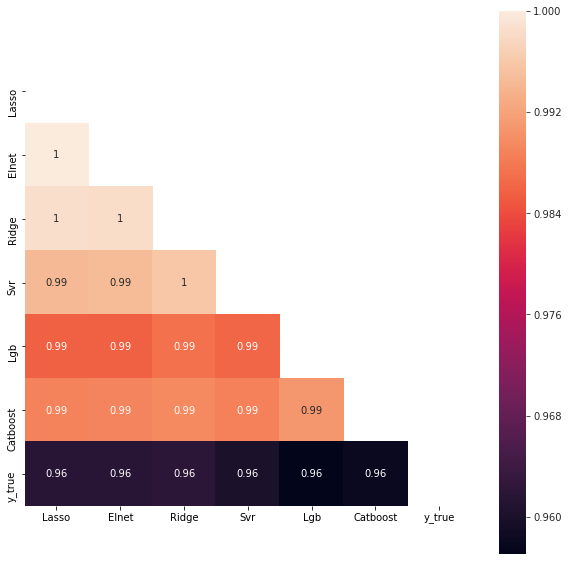

In [47]:
base_model_pred_train['y_true'] = y_train_normalized

fig, ax = plt.subplots(figsize=(10,10))
corrmat = base_model_pred_train.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corrmat, annot=True, square=True, mask=mask, ax=ax)

La correlación entre las prediciones es importante tenerla en cuenta para el modelo stacking. Cuanto menor correlacción haya entre dos prediciones, mejor resultado debería haber en el stacking. Por desgracia, todas son cercanas a 1.

In [48]:
base_model_pred_train.drop(['y_true'], axis=1, inplace=True)

In [49]:
bayes_cv_tuner = BayesSearchCV(
    estimator = Ridge(random_state=1),
    search_spaces = {
        'alpha': (0.001, 20.0, 'uniform'),
        'max_iter': (1000, 10000)
    },    
    scoring = make_scorer(rmsle_bayesian, greater_is_better=False),
    cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 5,
    n_iter = 40,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest RMSLE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    all_models.to_csv("stacking_cv_results.csv")

In [50]:
result = bayes_cv_tuner.fit(base_model_pred_train.values, y_train_normalized.values, callback=status_print)

Model #1
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #2
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #3
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #4
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #5
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #6
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #7
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #8
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #9
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #10
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #11
Best RMSLE: -0.107
Best params: {'max_iter': 7550, 'alpha': 8.202669073107423}

Model #12
Best RMSL

Como se puede ver, el stacking mejora el resultado del K-Fold aún más.

In [51]:
def KFoldEnsemble(train, test, y_train, k=5):
    kf = KFold(n_splits = k, random_state = 0, shuffle = True)
    rmsle_list = []
    
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(train)):
        trn_x, val_x = train.loc[trn_idx], train.loc[val_idx]
        trn_y, val_y = y_train[trn_idx], y_train[val_idx]
                
        model = Ridge(alpha = 8.202669073107423, max_iter=7550, random_state=1)
        model.fit(trn_x, trn_y)
        
        perm = PermutationImportance(model, random_state=1).fit(val_x, val_y)
        print('------------------------------------')
        print(eli5.format_as_text(eli5.explain_weights(perm, feature_names = train.columns.tolist(),top=300)))
        
        oof_preds[val_idx] = model.predict(val_x)
        sub_preds += model.predict(test) / k
        
        rmsle_train_fold = rmsle(np.expm1(trn_y), np.expm1(model.predict(trn_x)))
        rmsle_val_fold = rmsle(np.expm1(val_y), np.expm1(oof_preds[val_idx]))
        rmsle_list.append(rmsle_val_fold)
        
        print('RMSLE-train in fold {} is: {}'.format(n_fold, rmsle_train_fold))
        print('RMSLE-val in fold {} is: {}'.format(n_fold, rmsle_val_fold))
        print('------------------------------------')
    
    print('RMSLE mean is: {}'.format(np.mean(np.array(rmsle_list))))
    print('RMSLE full train is: {}'.format(rmsle(np.expm1(y_train), np.expm1(oof_preds))))
    
    train_pred = np.expm1(oof_preds)
    test_pred = np.expm1(sub_preds)
    
    return test_pred, train_pred

In [52]:
test_pred_stacking, train_pred_stacking = KFoldEnsemble(base_model_pred_train,
                                                        base_model_pred_test,
                                                        y_train_normalized.values,
                                                        k=5)

------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0595 ± 0.0048  Lgb
0.0541 ± 0.0101  Lasso
0.0515 ± 0.0113  Svr
0.0499 ± 0.0143  Elnet
0.0493 ± 0.0058  Ridge
0.0450 ± 0.0154  Catboost
RMSLE-train in fold 0 is: 0.10886781372869847
RMSLE-val in fold 0 is: 0.0991028227625157
------------------------------------
------------------------------------
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training

In [61]:
df_submission = pd.DataFrame()
df_submission['Id'] = test['Id']
df_submission['SalePrice'] = test_pred_stacking

df_submission.to_csv('submissions/stacking.csv', index=False)